# California Housing Market
***
## Purpose:
Real dataset based on California housing details. I will try new techniques I haven't used before and better understand how models will perform based on these new techniques and parameters.


### *Primary Question*

*Can we predict housing prices with supplied data?*


### *Fields in the dataset include:*

* Longitude             
* Latitude             
* Housing median age    
* Total rooms           
* Total bedrooms     
* Population          
* Households         
* Median income        
* Median house value **(Target Variable)**
* Ocean proximity 


## Findings:
* Decision Tree performed poorly
* Linear Regression performed slighlty better
* Random Forrests performed better of the three
* Selected and performed fine-tuning on the Random Forests Model
* Final MSE on the test set of 47766

## Outline:
1. Initial Investigation
2. Create Train and Test Sets
3. Exploratory Data Analysis
4. Model Preperation
5. Evaluate Models
6. Fine-Tune Model

In [1]:
# Import libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Import housing data
housing = pd.read_csv('datasets/housing/housing.csv')

## 1. Initial Investigation
***

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()
# There is one column with missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
# Location label counts
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### - Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CC88702C50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001CC88FE0D68>]], dtype=object)

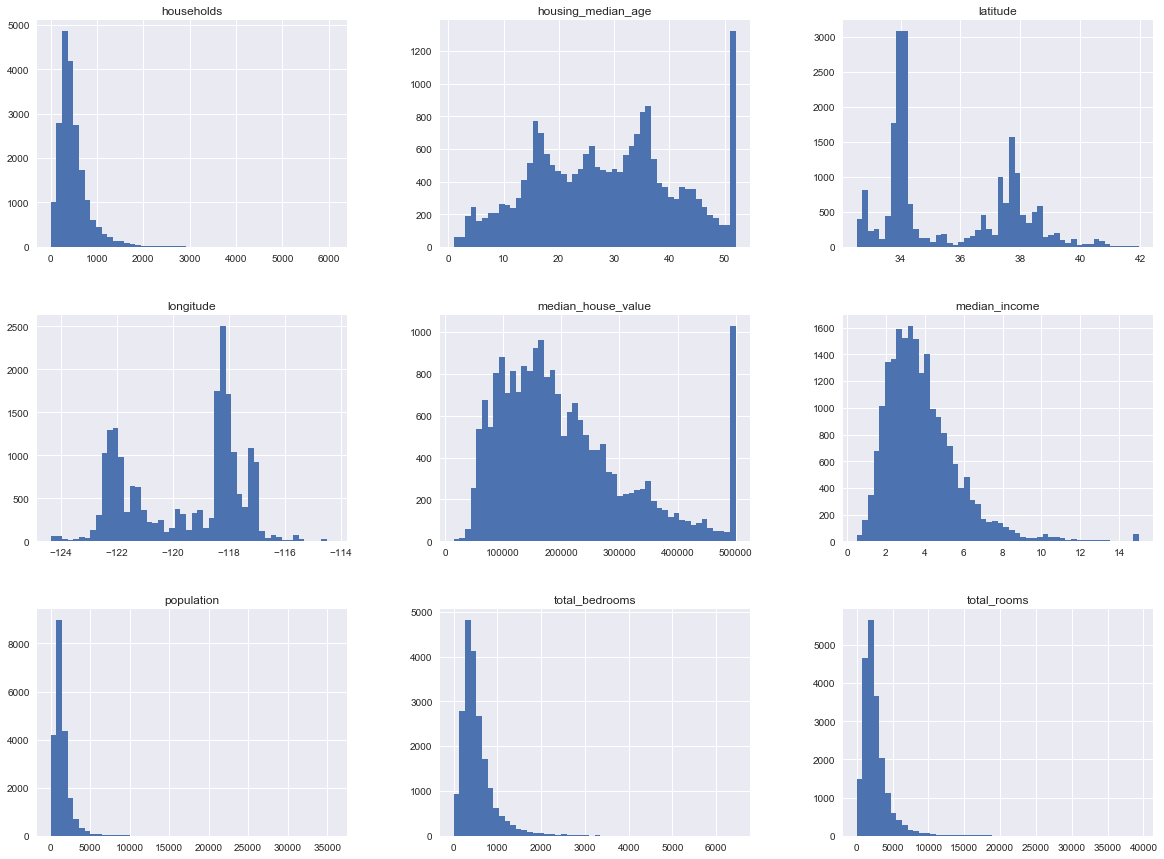

In [6]:
# Plot of histogram of each attribute
housing.hist(bins=50, figsize=(20,15))

### Takeaways:
* Median income, age, and home value have been converted to some other variable. Shouldn't be a problem except for possibly the median home value since that will be our target variable.
* There are quite a few skewed distributions I'll have to correct


## 2. Create Test and Train sets
***

In [7]:
# I will use a stratified sampling technique here to get a better selection to train off of
# I will base it off a "income category" that I will need to create
from sklearn.model_selection import StratifiedShuffleSplit

# Creating income category based on median income
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

# Now I will split based off the income categories
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# And check the distributions
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [8]:
# No longer need the income category label
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. Exploratory Data Analysis
***

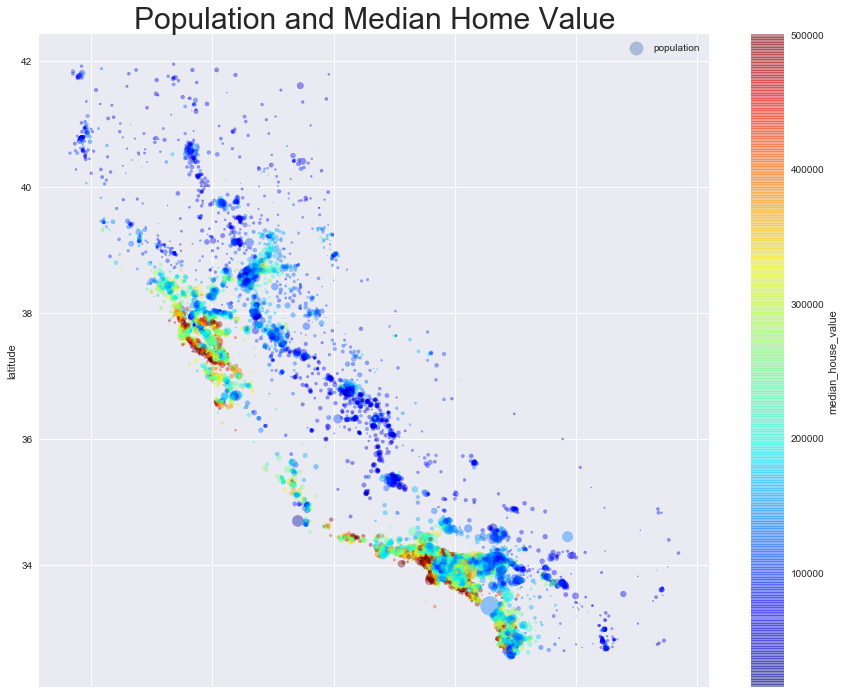

In [9]:
# Make a copy of the training set for analysis
housing = strat_train_set.copy()

# Plot based on lat and long
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             label="population", figsize=(15,12), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
plt.title('Population and Median Home Value', fontsize=30)

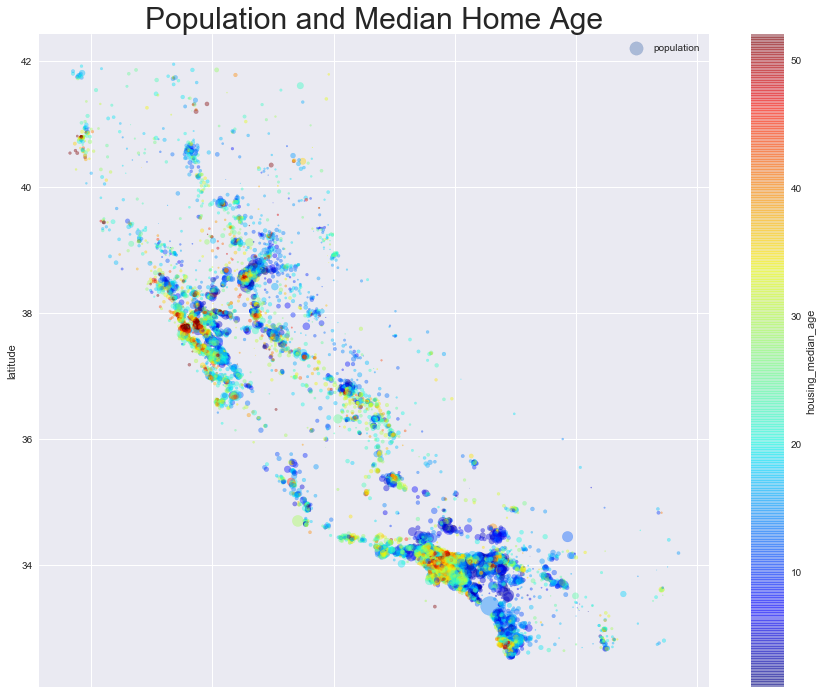

In [10]:
# with a slice on housing median age
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             label="population", figsize=(15,12), c="housing_median_age", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
plt.title('Population and Median Home Age', fontsize=30)

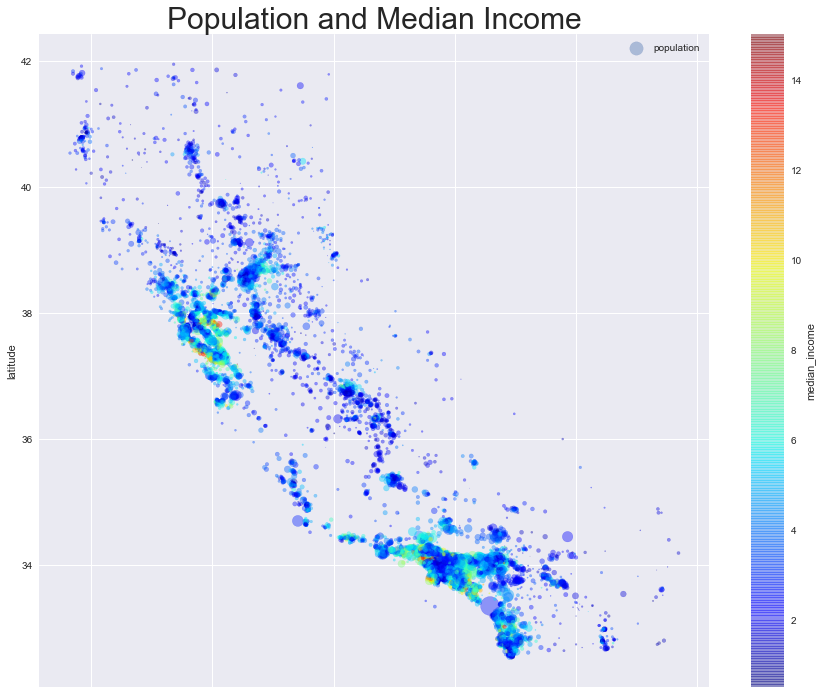

In [11]:
# with a slice on median income
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             label="population", figsize=(15,12), c="median_income", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
plt.title('Population and Median Income', fontsize=30)

### - Correlation Matrix

In [12]:
# Identifying correlations
corr_matrix = housing.corr()
# To our target variable, sorted
corr_matrix["median_house_value"].sort_values(ascending=False)

# Median income is highly correlated

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

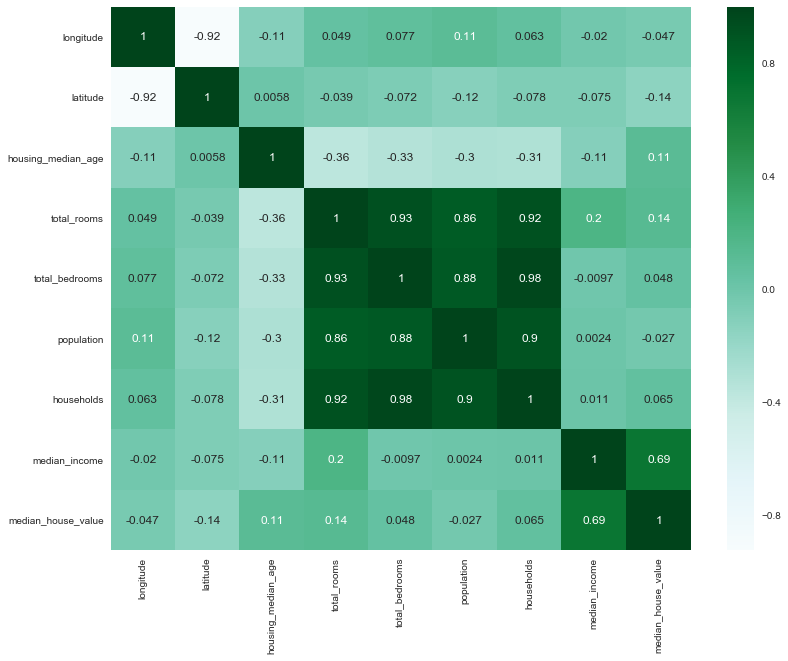

In [13]:
#  Create a heatmap on the correlation of each feature to the others
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values,
          cmap="BuGn",annot=True)

### - Pairplots

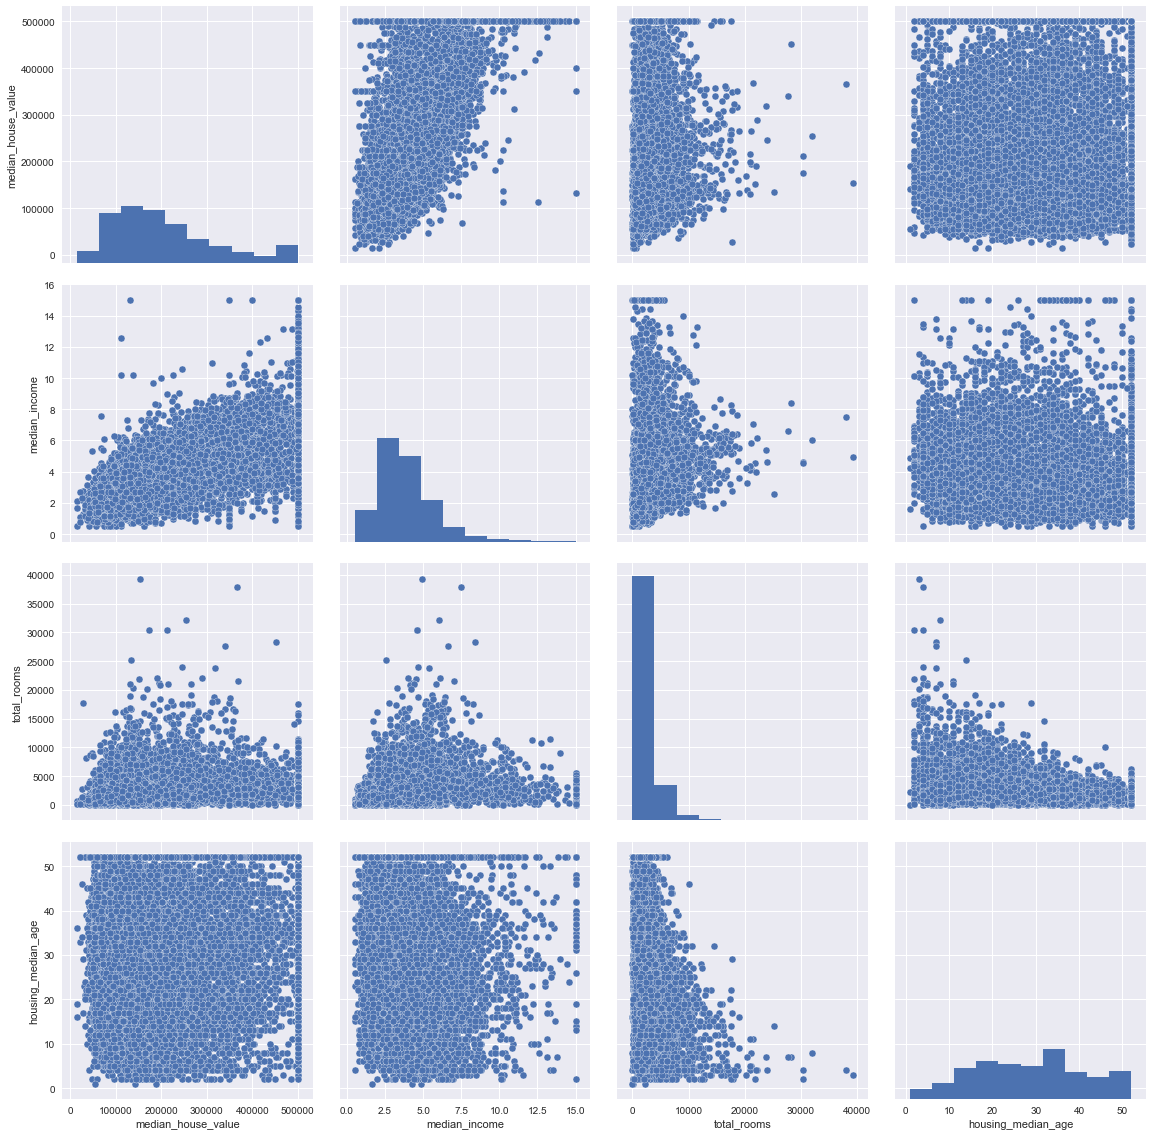

In [14]:
# Pairplots to show relationships of features
sns.pairplot(housing, vars=["median_house_value", "median_income", "total_rooms", "housing_median_age"], size=4)

# Some very interesting distributions
# Income still shows as the highest correlated with home value
# It's visible to see the caps the original dataset for income and value

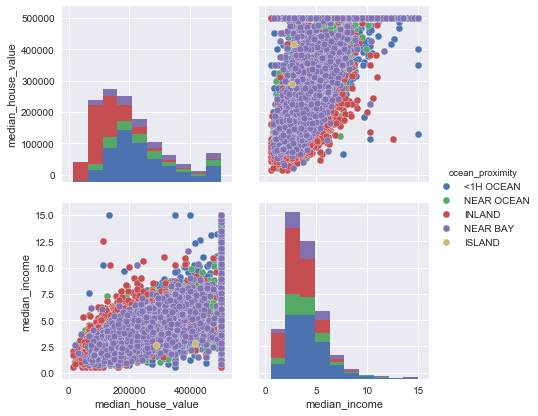

In [15]:
# same pairplots with a slice of proximity
sns.pairplot(housing, vars=["median_house_value", "median_income"], 
             size=3, hue='ocean_proximity')

In [16]:
# There are some good variables so lets see about deriving a few others from those that have the most promies
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# Calculate correlation and print
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## 4. Model Preperation
***

In [17]:
# Create two sets of our data to seperate out the target and features
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Will need to impute the missing values for total bedrooms
# I will use the median to impute values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

# Dropping ocean proximity
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

# Now transform the missing instances
X = imputer.transform(housing_num)
# Turn back to a DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

# Necessary to convert all categorical variables to binary columns
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)

housing_cat = housing["ocean_proximity"]
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

### - Transformation Pipeline

In [18]:
# This is a transformation pipleline from the O'Reilly book:
# "Hands on Machine Learning"
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('imputer', Imputer(strategy="median")), ('attribs_adder', 
                        CombinedAttributesAdder()), ('std_scaler', StandardScaler()),])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

## 5. Evaluate Models
***

### - Linear Regression

In [19]:
# Start with a linear regression model
from sklearn.linear_model import LinearRegression

# Train the model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Now make the predictions
predict = lin_reg.predict(some_data_prepared)

# Calculate the mean squared error (MSE)
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

# That is a large error in the context of the data

68628.198198489234

### - Decision Tree

In [20]:
# Try a better model with the Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Train the model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

# Make predictions and evaluate
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Unlikely there is no error, will try cross validation to evaluate

0.0

### - Cross Validation

In [21]:
# K-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# Program to run through the scores (10x)
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())
    
display_scores(tree_rmse_scores)

# Scores show that the decision tree performed worse than the LR algo
# This was my first time using cross-validation and it certainly exposes a lot

Scores: [ 68632.80828554  67117.8649518   71576.80747492  69516.32205389
  71071.41310283  74524.75850564  70068.59882059  70690.35979326
  76788.75337407  68747.12073865]
Mean: 70873.4807101
Standard deviation: 2739.08822622


In [22]:
# I wat to see what cross-validation shows for the linear regression model from before
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


### - Random Forests

In [23]:
# I've had much more luck with random forests
from sklearn.ensemble import RandomForestRegressor

# Train the random forest model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

# Evaluate the model
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52588.84984802  50101.14012548  51815.54508822  54195.87524404
  53054.13908042  56374.30377499  52012.25418556  50013.5434516
  55929.64489203  52056.64145771]
Mean: 52814.1937148
Standard deviation: 2044.90611884


### - Gradient Boosting

In [24]:
# Try some gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

# Train the model
gb_model = GradientBoostingRegressor()
gb_model.fit(housing_prepared, housing_labels)

# Evaluate the model
gb_model_scores = cross_val_score(gb_model, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
gb_rmse_scores = np.sqrt(-gb_model_scores)
display_scores(gb_rmse_scores)

Scores: [ 51363.1135946   49980.39555906  53041.45399288  55636.83003288
  53082.41691797  56122.89188085  50733.65933909  51085.18161884
  56640.82818766  53921.04891293]
Mean: 53160.7820037
Standard deviation: 2261.8471937


### Takeaways:
* Random Forests performed the best out of all the models
* I will fine-tune the model in the following section

## 6. Fine-Tune Model
***

### - Grid Search

In [25]:
# Use a grid search to tune hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# execute the grid search
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
# Identify the best values
grid_search.best_estimator_
# Max features 8
# Estimators 30

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
# Score the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63825.0479302 {'max_features': 2, 'n_estimators': 3}
55643.8429091 {'max_features': 2, 'n_estimators': 10}
53380.6566859 {'max_features': 2, 'n_estimators': 30}
60959.1388585 {'max_features': 4, 'n_estimators': 3}
52740.5841667 {'max_features': 4, 'n_estimators': 10}
50374.1421461 {'max_features': 4, 'n_estimators': 30}
58661.2866462 {'max_features': 6, 'n_estimators': 3}
52009.9739798 {'max_features': 6, 'n_estimators': 10}
50154.1177737 {'max_features': 6, 'n_estimators': 30}
57865.3616801 {'max_features': 8, 'n_estimators': 3}
51730.0755087 {'max_features': 8, 'n_estimators': 10}
49694.8514333 {'max_features': 8, 'n_estimators': 30}
62874.4073931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54561.9398157 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59416.6463145 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52660.245911 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.0168279 {'bootstrap': False, 'max_features': 4, 'n_estima

### - Randomized Search

In [28]:
# Comes together a lot like the GridSearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CC90259588>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CC90259E80>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

In [29]:
# Identify the best values
rnd_search.best_estimator_
# Max features 7
# Estimators 180

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [30]:
# Now get a listing of iteration results
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50798.3025423 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50776.7360494 {'max_features': 3, 'n_estimators': 75}
50682.7075546 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50472.6107336 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


### - Final Evaluation

In [31]:
# Time toi use the test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

test_mse = mean_squared_error(y_test, final_predictions)
test_rmse = np.sqrt(test_mse)
test_rmse

47766.003966433083

### Takeaways:
* Grid Search did a great job identifying the best parameters and improved the MSE from 52485 to 49694
* Randomized search did even better with an MSE of 49147
* Final MSE is 47766